In [1]:
import numpy as np
import os
import pickle
import time

import matplotlib.pyplot as plt

## Define some function

In [2]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [3]:
def get_loglikelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                 Njets=10000,
                                 pt_cut=30.0,
                                 likelihood="marginal",
                                 datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
        
    loglikelihood_surface = np.zeros((Njets, n_lambda))
    
    for i in range(n_lambda):
        model_params = {"delta_min": pt_cut, "lam": lambda_vals[i]}

        in_filename = os.path.join(datadir, "trellis_{}_jets_1D_lambda_{:n}_ptcut_{:n}_{}_with_perm.pkl".format(
            Njets,
            int(lambda_vals[i])*1000,
            int(pt_cut),
            i))
        with open(in_filename, "rb") as fd:
            results = pickle.load(fd, encoding='latin-1')

        for k in range(Njets):
            loglikelihood_surface[k,i] = results[key][k]
                
    return loglikelihood_surface

In [4]:
def clean_array(loglikelihood_surface_array):
    bad_indices = []
    for ix, entry in enumerate(loglikelihood_surface_array):
        if np.isnan(entry).sum() > 0:
            bad_indices.append(ix)
    bad_indices = np.array(bad_indices)

    good_indices = np.arange(loglikelihood_surface_array.shape[0])
    for bad_ix in bad_indices:
        good_indices = good_indices[good_indices != bad_ix]
        
    return loglikelihood_surface_array[good_indices], good_indices

## Define parameters

In [5]:
lambda_truth = 2.4
pt_cut_truth = 30.0

n_lambda = 150

#lambda_min = 1.6   # OLD VALUES
#lambda_max = 2.75  # OLD VALUES

lambda_min = 1.9
lambda_max = 3.05

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

Njets = 20000

## Load the observed dataset

In [6]:
Njets = 100000
gt_trees = load_jets("data", "ginkgo_{}_jets_no_cuts_lambda_{}_pt_min_{}_jetp_400_with_perm".format(Njets,
                                                                                                    int(lambda_truth*10),
                                                                                                    int(pt_cut_truth)))  # My test file

### Check truth values

In [7]:
truth_bin = None
        
for ix, x in enumerate(lambda_vals >= lambda_truth):
    if x.item() is True:
        truth_bin = ix-1
        break
        
truth_bin, lambda_vals[truth_bin], lambda_vals[truth_bin+1], lambda_truth

(64, 2.393959731543624, 2.401677852348993, 2.4)

## Find the likelihood surface and filter the arrays

In [8]:
Njets = 1000
loglikelihood_surface_array = get_loglikelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                                        Njets=Njets,
                                                        pt_cut=pt_cut_truth,
                                                        likelihood="marginal")

In [9]:
loglikelihood_surface_array, good_indices = clean_array(loglikelihood_surface_array)

In [10]:
gt_trees = (np.array(gt_trees)[good_indices]).tolist()

## Plot the likelihood surface /  $\chi^2$ values

In [11]:
total_loglikelihood_surface = np.sum(loglikelihood_surface_array, axis=0)

In [12]:
mle_coords = np.unravel_index(np.argmax(total_loglikelihood_surface, axis=None), total_loglikelihood_surface.shape)[0]

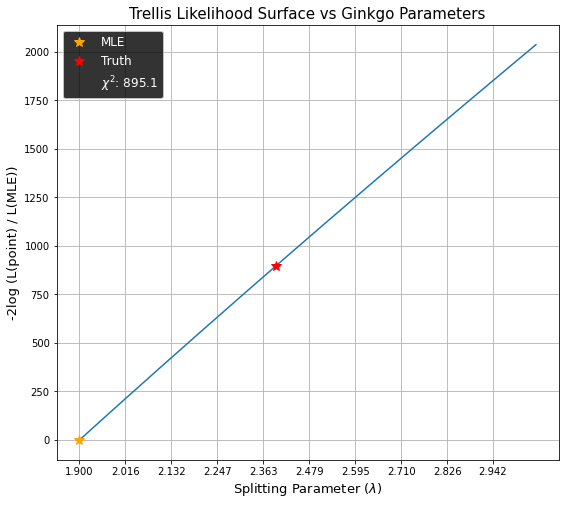

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_loglikelihood_surface-total_loglikelihood_surface[mle_coords])

chi2_marginal = Z[truth_bin]

ax.plot(lambda_vals, Z)
ax.plot(lambda_vals[mle_coords], Z[mle_coords], '*', color="orange", label="MLE", markersize=10)
ax.plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);

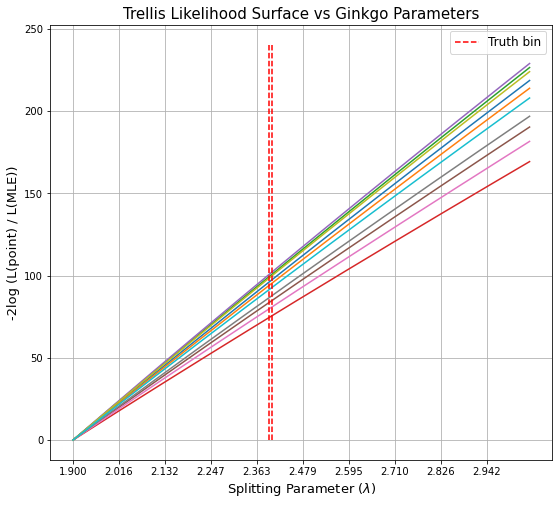

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

arr = np.arange(loglikelihood_surface_array.shape[0])

for seed in range(30, 40):
    np.random.seed(seed)

    random_indices = np.random.choice(arr, 100, replace=False)

    batch_loglikelihood_surface = np.sum(loglikelihood_surface_array[random_indices], axis=0)
    Z = -2*(batch_loglikelihood_surface-batch_loglikelihood_surface.max())

    ax.plot(lambda_vals, Z)
    
y_min, y_max = ax.get_ylim()
    
ax.vlines(lambda_vals[truth_bin], ymin=0, ymax=y_max, colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin", zorder=1e4)
ax.vlines(lambda_vals[truth_bin+1], ymin=0, ymax=y_max, colors="red", linestyle="dashed", linewidth=1.5, zorder=1e4)

ax.grid()
ax.legend(fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);